# Neural machine translation with attention

## Setup

In [1]:
!pip install "tensorflow-text>=2.10"
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

This class is used to check shapes throughout the tutorial.


In [3]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## The data

The Project uses a language dataset similar with provided by [Anki](http://www.manythings.org/anki/). This dataset contains language translation pairs separated by tab in the format:

```
I know a few things.	Waan muraasa beeka.
```

### Download and prepare the dataset

In [4]:
# Download the file
import pathlib
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/My Drive/MT
path_to_file = "eng_or_tr_final.txt"

Mounted at /content/drive/
/content/drive/My Drive/TTS


In [5]:
def data_loader(f_name):
    target = []
    context = []
    with open(f_name, 'r', encoding='utf-8') as f:
        for line in f:
            trg, cnt = line.strip().split('\t')
            target.append(trg)
            context.append(cnt)
    return np.array(target), np.array(context)

In [6]:
target_raw, context_raw = data_loader(path_to_file)
print("Length of the dataset: ", len(context_raw))
print("Sample sentece on line 800:", context_raw[800])
print("Sample transcription on line 800:", target_raw[800])


Length of the dataset:  120169
Sample sentece on line 800: Sirbuu nan danda'a.
Sample transcription on line 800: I can sing.


### Create a tf.data dataset

In [7]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [8]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Intalti ani sitti hime kun as jiraatti.'
 b'Halkan kana, hundi keenya shubbisaa haa deemnu.'
 b'Kaardii taphachuu nan jibba.' b'Humna tokkollee natti hafe hin jiru.'
 b'Isa hin argine.'], shape=(5,), dtype=string)

tf.Tensor(
[b'The girl I told you about lives here.'
 b"Tonight, let's all go dancing." b'I hate playing cards.'
 b"I don't have any energy left." b"I didn't see him."], shape=(5,), dtype=string)


### Text preprocessing

#### Standardization

In [9]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  #text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and selected punctuation.
  text = tf.strings.regex_replace(text, "[^ a-z.?!,']", '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['<s>', text, '</s>'], separator=' ')
  return text

In [10]:
example_text = example_context_strings[0]

In [11]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Intalti ani sitti hime kun as jiraatti.
<s> intalti ani sitti hime kun as jiraatti . </s>


#### Text Vectorization

In [12]:
max_vocab_size = 30000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

The `TextVectorization` layer and many other [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fit`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:

In [13]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['', '[UNK]', '<s>', '</s>', '.', 'hin', 'toom', '?', 'akka', 'ture']

In [14]:
print("Length of vocabulary of Afaan Oromo:", len(context_text_processor.get_vocabulary()))

Length of vocabulary of Afaan Oromo: 27527


That's the Afaan Oromoo `TextVectorization` layer, now build and `.adapt()` the English one:

In [15]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '<s>', '</s>', '.', 'the', 'to', 'i', 'tom', 'you']

In [16]:
print("Length of vocabulary of English:", len(target_text_processor.get_vocabulary()))

Length of vocabulary of English: 17154


Now these layers can convert a batch of strings into a batch of token IDs:

In [17]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 722, 26, 127, 187, 21, 93, 2417, 4, 3],
 [2, 114, 14, 17, 90, 91, 1162, 110, 728, 4, 3],
 [2, 830, 325, 20, 363, 4, 3]]>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [18]:
example_tokens[0]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([   2,  722,   26,  127,  187,   21,   93, 2417,    4,    3])>

In [19]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'<s> intalti ani sitti hime kun as jiraatti . </s>'

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

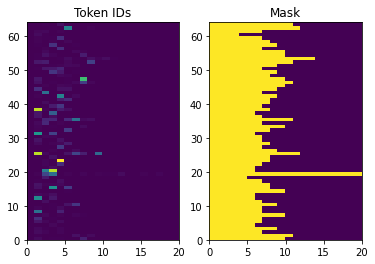

In [20]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

### Process the dataset



The `process_text` function below converts the `Datasets` of strings, into  0-padded tensors of token IDs. It also converts from a `(context, target)` pair to an `((context, target_in), target_out)` pair for training with `keras.Model.fit`. Keras expects `(inputs, labels)` pairs, the inputs are the `(context, target_in)` and the labels are `target_out`. The difference between `target_in` and `target_out` is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [21]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

Here is the first sequence of each, from the first batch:

In [22]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[  2  71  27 263   5 143   4   3   0   0]

[  2  86  40 920   6 135  32   5 195   4]
[ 86  40 920   6 135  32   5 195   4   3]


## The encoder/decoder


Before getting into it define constants for the model:

In [23]:
UNITS = 256

### The encoder

In [24]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

Try it out:

In [25]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 16)
Encoder output, shape (batch, s, units): (64, 16, 256)


### The attention layer

In [26]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [27]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 16, 256)
Target sequence, shape (batch, t, units): (64, 20, 256)
Attention result, shape (batch, t, units): (64, 20, 256)
Attention weights, shape (batch, t, s):    (64, 20, 16)


The attention weights will sum to `1` over the context sequence, at each location in the target sequence.

In [28]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1).round()

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.], dtype=float32)



Here are the attention weights across the context sequences at `t=0`:

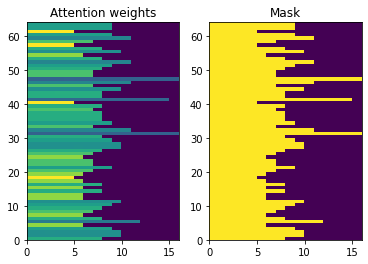

In [29]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


Because of the small-random initialization the attention weights are initially all close to `1/(sequence_length)`. The model will learn to make these less uniform as training progresses.

### The decoder

Here is the `Decoder` class' initializer. The initializer creates all the necessary layers.

In [30]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('<s>')
    self.end_token = self.word_to_id('</s>')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Training

In [31]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

That will be sufficient for training. Create an instance of the decoder to test out:

In [32]:
decoder = Decoder(target_text_processor, UNITS)

In training decoder will be used like this:

Given the context and target tokens, for each target token it predicts the next target token. 

In [33]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 16, 256)
input target tokens shape: (batch, t) (64, 20)
logits shape shape: (batch, target_vocabulary_size) (64, 20, 17154)


#### Inference

To use it for inference we'll need a couple more methods:

In [34]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [35]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\<s\> *', '')
  result = tf.strings.regex_replace(result, ' *\<\/s\> *$', '')
  return result

In [36]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

With those extra functions, we can write a generation loop:

In [37]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'lemon only dimlylit indoor twin stone suits directed wagon related',
       b'midseason reflection brightly lasts abrupt frames hercules aurora hail topology',
       b'sixteen reaches capture junta ranching negotiated rocks regaining flight robbed'],
      dtype=object)

Since the model's untrained, its output items from the vocabulary almost uniformly at random.

## The model

Now that we have all the model components, we can combine them to build the model for training:

In [38]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

During training the model will be used like this:

In [39]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 16)
Target tokens, shape: (batch, t) (64, 20)
logits, shape: (batch, t, target_vocabulary_size) (64, 20, 17154)


### Train

For training, we need to implement our own masked loss and accuracy functions:

In [40]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [41]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

Configure the model for training:

In [42]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [43]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 9.749987, 'expected_acc': 5.829544129649061e-05}

That should roughly match the values returned by running a few steps of evaluation:

In [44]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 8s 59ms/step - loss: 9.7503 - masked_acc: 0.0000e+00 - masked_loss: 9.7503


{'loss': 9.750264167785645,
 'masked_acc': 0.0,
 'masked_loss': 9.750264167785645}

In [45]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/100
100/100 [==============================] - 40s 253ms/step - loss: 5.7900 - masked_acc: 0.2086 - masked_loss: 5.7900 - val_loss: 4.8023 - val_masked_acc: 0.2969 - val_masked_loss: 4.8023
Epoch 2/100
100/100 [==============================] - 16s 163ms/step - loss: 4.4127 - masked_acc: 0.3346 - masked_loss: 4.4127 - val_loss: 4.1658 - val_masked_acc: 0.3583 - val_masked_loss: 4.1658
Epoch 3/100
100/100 [==============================] - 12s 123ms/step - loss: 3.9634 - masked_acc: 0.3774 - masked_loss: 3.9634 - val_loss: 3.7679 - val_masked_acc: 0.3990 - val_masked_loss: 3.7679
Epoch 4/100
100/100 [==============================] - 12s 121ms/step - loss: 3.6311 - masked_acc: 0.4238 - masked_loss: 3.6311 - val_loss: 3.4264 - val_masked_acc: 0.4403 - val_masked_loss: 3.4264
Epoch 5/100
100/100 [==============================] - 10s 103ms/step - loss: 3.3212 - masked_acc: 0.4629 - masked_loss: 3.3212 - val_loss: 3.1656 - val_masked_acc: 0.4770 - val_masked_loss: 3.1656
Epoch 6/10

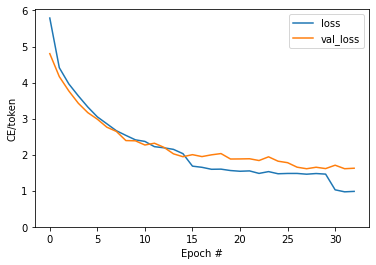

In [46]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

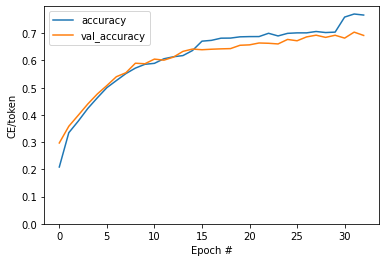

In [47]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Translate


In [48]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  result = tf.strings.regex_replace(result, r' ([.?!]) ', r'\1')
  return result

Here are the two helper methods, used above, to convert tokens to text, and to get the next token:

In [49]:
result = model.translate(['Galatoomaa.']) # Thanks
result = result[0].numpy().decode()
result

'thank you.'

Use that to generate the attention plot:

In [50]:
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

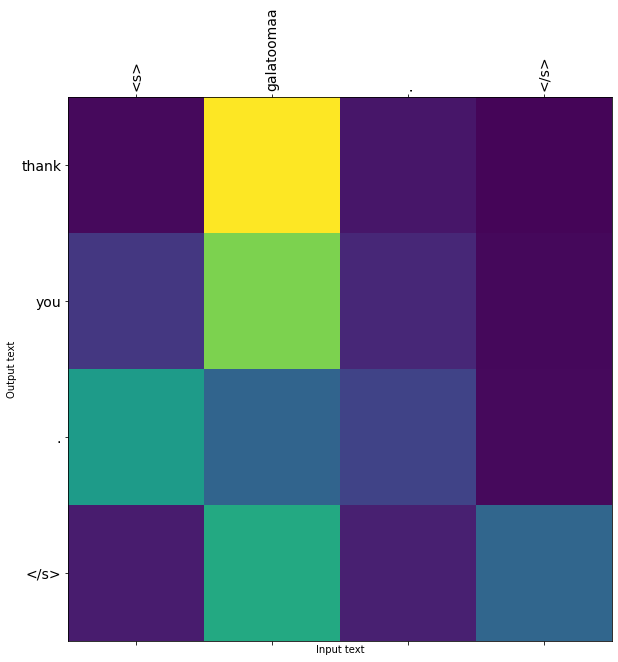

In [51]:
model.plot_attention('Galatoomaa.') # Thanks

Translate a few more sentences and plot them:

CPU times: user 565 ms, sys: 3.78 ms, total: 568 ms
Wall time: 832 ms


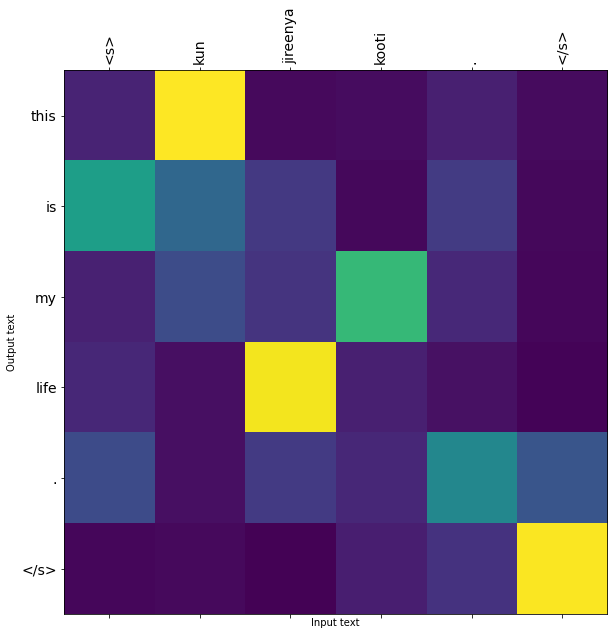

In [98]:
%%time
# This is my life.
model.plot_attention('Kun jireenya kooti.') #This is my life

CPU times: user 313 ms, sys: 2.7 ms, total: 316 ms
Wall time: 348 ms


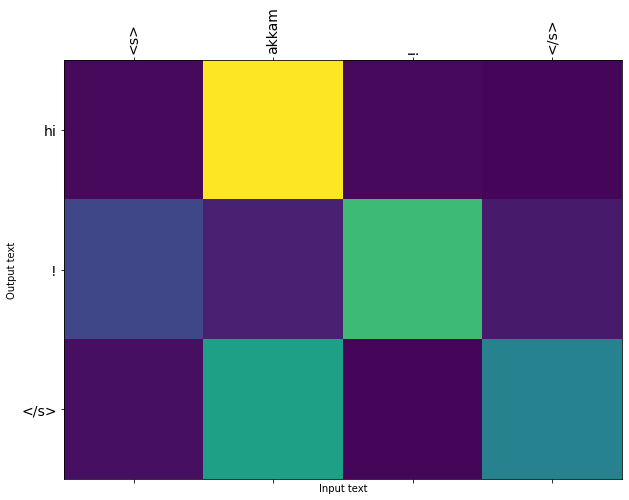

In [99]:
%%time
 # Try to find out.'
model.plot_attention("Akkam!") #Hello!

The raw data is sorted by length, so try translating the longest sequence:

In [100]:
long_text = context_raw[-1]
import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 Various sport competitions, exhibitions and symposiums are also
scheduled events of the festival.


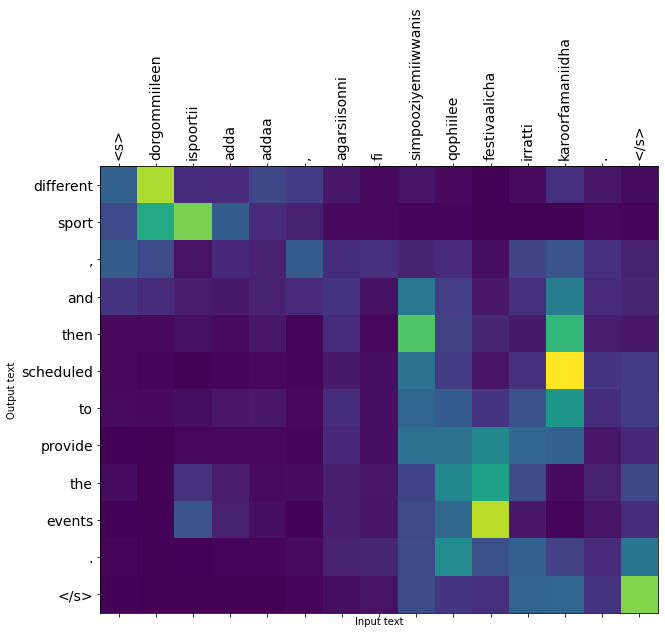

In [55]:
model.plot_attention(long_text)

The `translate` function works on batches:

In [105]:
inputs = [
    'As baayyee qorra.', # "It's really cold here."
    'Kun jireenya kooti.', # "This is my life."
    'Kutaan isaa jeequmsa.' # "His room is a mess"
]

In [106]:
%%time
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

it's very cold here.
this is my life.
his room is a mess.

CPU times: user 989 ms, sys: 9.9 ms, total: 999 ms
Wall time: 974 ms


In [68]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

it's very cold here. 
this is my life. 
his room is a mess.

CPU times: user 367 ms, sys: 4.26 ms, total: 371 ms
Wall time: 364 ms


So overall this text generation function mostly gets the job done, but so you've only used it here in python with eager execution. Let's try to export it next:

### Export

If you want to export this model you'll need to wrap the `translate` method in a `tf.function`. That implementation will get the job done:


In [59]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [60]:
export = Export(model)

Run the `tf.function` once to compile it:

In [61]:
%%time
_ = export.translate(tf.constant(inputs))

CPU times: user 1min 6s, sys: 1.5 s, total: 1min 8s
Wall time: 1min 7s


In [69]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

it's very cold here.                                            
this is my life.                                            
his room is a mess.                                           

CPU times: user 164 ms, sys: 14.6 ms, total: 178 ms
Wall time: 238 ms


Now that the function has been traced it can be exported using `saved_model.save`:

In [63]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

CPU times: user 1min 33s, sys: 2.65 s, total: 1min 36s
Wall time: 1min 36s


In [64]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

CPU times: user 1min 1s, sys: 1.38 s, total: 1min 3s
Wall time: 1min 3s


In [70]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

it's very cold here.                                            
this is my life.                                            
his room is a mess.                                           

CPU times: user 162 ms, sys: 16.9 ms, total: 179 ms
Wall time: 234 ms


In [95]:
result = reloaded.translate(["Kottu."])
print(result[0].numpy().decode())

come on.                                              
